# CAO Points

1. [Introduction](#Introduction)
1. [Imports](#Imports)
1. [Acquiring the data](#Acquiring-the-data)
1. [Parsing the data](#Parsing-the-data)
    1. [Data supplied as preformatted text embedded in a HTML page](#Data-supplied-as-preformatted-text-embedded-in-a-HTML-page)
    1. [Data supplied as an Excel spreadsheet](#Data-supplied-as-an-Excel-spreadsheet)
    1. [Data held as a one-column-per-page table in a PDF file](#Data-held-as-a-one-column-per-page-table-in-a-PDF-file)
    1. [Data held in a multiple-column-per-page and multiple-page-per-column table in a PDF file](#Data-held-in-a-multiple-column-per-page-and-multiple-page-per-column-table-in-a-PDF-file)
    1. [Putting it all together](#Putting-it-all-together)
1. [Analysing the data](#Analysing-the-data)

## Introduction

The CAO website publishes third level entry points data dating back to 1998 on its [website](http://www.cao.ie). The data is not particularly accessible, using a number of different file formats and with formatting and coding inconsistencies within those formats from year to year. The most recent data, 2021, is released as preformatted, whitespace-separated, columnar text embedded in a html page. The data relating to the years 2001 - 2004 follow the same pattern. The 2020 data is supplied in the form of an excel spreadsheet. The data for the years 2005 and 2008 - 2019 are released as pdf files containing a single table which is read straight down from one page to the next, while the 2006 and 2007 data are also supplied in a pdf file but with a more complex multi-column structure. Finally, the 1998 - 2000 data takes the form of scanned pdf files. It is intended here to extract the data from all but the scanned (1998-2000) data sources, clean and homogenise it, and place it all in a single pandas DataFrame for analysis.

The attributes of interest for comparison between the various years' datasets are `Course Code`, `Course Name`, `Institution Name`, `EOS` (*End of Season*), which is the number of points achieved by the last applicant to be offered a place on the course, and `Mid`, which is the median of the scores of all applicants offered a place on the course. The level (whether or not the course is level 8), and a few edge-case indicators are also recorded as boolean attributes. These indicators are `Test`, indicating whether entry to the course is dependent on success in special test, portfolio, or interview process, `Not All`, indicating that not every applicant at the `EOS` points level was awarded a place, `AQA`, or *All Qualified Applicants*, meaning that all applicants with the minimum points were offered a place, and `New Comp`, which seems to indicate a course for which the points have increased in round 2.

## Imports

In [1]:
# Data analysis library
import pandas as pd
# Plotting library
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# PDF table parsing
from tabula import read_pdf
# Retrieval of resources from WWW
import requests
# URL construction
from requests.compat import urljoin
# Various, mainly path construction
import os
# Creation of datetime strings for filenames
from datetime import datetime
# Regular expressions
import re
# Numerical computing
import numpy as np
# Calculate hashes for file change detection
import hashlib
# Greedy zip() implementation
from itertools import zip_longest


## Acquiring the data

First, a dictionary is constructed mapping remote to local filenames. With the exception of the 2020 data, which is supplied in a single Excel file containing data for all levels, the data is supplied in two files, one containing the points for level 8 courses, and the other for levels 7 and 6.

In [2]:
# Dict of source filenames mapped to local filenames
points_urls  = (
    {'l8.php'                  : 'cao_2021_lvl8.html',
     'l76.php'                 : 'cao_2021_lvl76.html',
     'CAOPointsCharts2020.xlsx': 'cao_2020_lvl876.xlsx',
     'CAOPointsCharts2021.xlsx': 'cao_2021_lvl876.xlsx'}
     )

# The rest of points_urls can be assembled 
# programmatically as filenames follow a pattern

# List of years as 2-digit strings from 2019 to 2005
years = [str(i).zfill(2) for i in range(19, 4, -1)]
# For each year (2019 down to 2005)
for year in years:
    # remote level names
    levels = ('lvl8', 'lvl76')
    # local level names
    local_levels = levels
    
    # 2011 and 2012 data is missing second 'l' from filenames
    if year in ('12', '11'):
        levels = ('lv8', 'lv76')
        
    # For each level 
    for level, local_level in zip(levels, local_levels):
        # construct remote filename
        remote_name = level + '_' + year + '.pdf'
        # construct local filename
        local_name = 'cao_20' + year + '_' + local_level + '.pdf'
        # Add remote and local filenames to points_urls dict
        points_urls[remote_name] = local_name

# List of years as 2-digit strings from 2004 to 2001
years = [str(i).zfill(2) for i in range(4, 0, -1)]
for year in years:
    # remote level names
    levels = ('deg', 'dip')
    # local level names
    local_levels = ('lvl8', 'lvl76')

    # add remote and local filenames to points_urls dict
    for level, local_level in zip(levels, local_levels):
        remote_name = level + year + '.htm'
        local_name = 'cao_20' + year + '_' + local_level + '.html'
        points_urls[remote_name] = local_name


Next, the dict defined above is used to retrieve all of the desired data files. If a file does not already exist in the data directory then it is saved using a consistent file naming pattern, and a timestamped copy is saved to the backup directory. If the file to be written already exists in the data directory then its md5 sum is compared with that of the newly downloaded file. If the hashes match then nothing more is done but, if they don't, the old file is overwritten with the new one, and a timestamped copy of the new file is saved to the backup directory. In this way, changes to the data are recorded, and the outdated data is preserved.

In [3]:
def get_cao_source_data(base_url, points_urls, 
                        data_dir, backup_dir, 
                        verbose=False):
    """Download CAO data from website and save to local files.
       This function will check if a local file exists before 
       overwriting and if so will check if it has changed since
       the last time it was downloaded. Each time file is written 
       a timestamped backup is created.

    Args:
        base_url (str): The base URL for the CAO website.
        points_urls (dict): A dictionary of remote filenames 
                            mapped to local filenames.
        data_dir (str): The directory to save the downloaded files.
        backup_dir (str): The directory to save the backups.
        verbose (bool, optional): When True, ouputs progress messages 
                                  during check/write process. 
                                  Defaults to False.
    """
    # for each of the source files 
    for url in (points_urls):
        # construct url and fetch content
        response = requests.get(urljoin(base_url, url))

        try:
            # attempt to open any previously downloaded local file
            with open(os.path.join(data_dir, points_urls[url]), "rb") as f:
                # Calculate md5 hashes local and remote files
                md5_local = hashlib.md5(f.read()).hexdigest()
                md5_response = hashlib.md5(response.content).hexdigest()

                # Set write_flag to True if hashes do not match
                write_flag = (md5_local != md5_response)

        except FileNotFoundError:
            # if local file doesn't exist set write_flag to True 
            write_flag = True

        # If write_flag is True
        if write_flag:
            if verbose:
                print(f"File: {points_urls[url]}", 
                       "has changed since last download. Updating...")
            # construct backup filename with timestamp
            fname, extension = os.path.splitext(points_urls[url])
            timestamp = datetime.now().strftime("_%Y%m%d_%H%M%S")
            filename = fname + timestamp + extension

            # write backup to backup_dir
            with open(os.path.join(backup_dir, filename), 'wb') as f:
                f.write(response.content)

            # write remote file to data_dir, overwriting any previous file
            with open(os.path.join(data_dir, points_urls[url]), 'wb') as f:
                f.write(response.content)
        else:
            if verbose:
                print(f"File: {points_urls[url]}",
                       " has not changed since last download. Skipping...")

In [4]:
# Location of CAO points data
base_url = 'http://www2.cao.ie/points/'
# Local data directory
data_dir = 'data/cao'
backup_dir = 'data/cao/backup'

get_cao_source_data(base_url=base_url, 
                    points_urls=points_urls, 
                    data_dir=data_dir, 
                    backup_dir=backup_dir, 
                    verbose=False)

## Parsing the data

At this point, all of the necessary pdf, html, and xslx files have been downloaded and reside in the data directory. Next, each file must be loaded and parsed, and the desired data extracted and cleaned. The CAO data files can be divided into four types; html files containing preformatted text, Microsoft Excel files, PDF files containing tables in portrait orientation with only one page-column per page, and PDF files with landscape oriented pages which contain multiple page-columns per page. Each of these types requires a different approach and so are dealt with separately below. Many of the individual data files have quirks which are dealt with mainly by paramaterising them in the parsing function for that particular file type. Each of the parsing functions has default values set which align with those necessary for parsing the majority of their inputs and each of the sections below ends with a dict containing the arguments each input file must supply to the parsing function in order to be parsed correctly.

While all of the parsing logic is developed in the functions in each of the subsections below, the functions are not acutally called until the [Putting it all together](#Putting-it-all-together) section that follows.

### Data supplied as preformatted text embedded in a HTML page
#### 2021, 2004, 2003, 2002, and 2001

The function `read_cao_html` takes the paths to the level 8 and level 76 files for a particular year, parses them both, extracting course codes and names, 'end of season' and median points, level, institution name, and the *test*, *not all*, *AQA*, and *new comp* status for every course listed. The bulk of the extraction work is performed by the regular expression; 

```python
f'^([A-Z]{{2}}[0-9]{{3}})\s+(\S.{{{name_len-1}}})\s+(\S+)?\s+(\S+)?')
```
This expression looks a little odd because it uses f-string interpolation to insert the variable `name_len`. Because this requires a curly brace, curly braces which surround quantifiers in the regular expression must be escaped by doubling them [2]. `{name_len}` is itself a quantifier, hence the triple curly brace - two for the quantifier and one for the f-string interpolation. The regex has four capture groups (delimited by parentheses) each separated by one or more whitespace characters. The capture groups are as follows: 
- `^([A-Z]{{2}}[0-9]{{3}})`. This group, preceded by a caret (^), indicating that it should be anchored to the start of a line, captures two upper case characters followed by three digits at the beginning of a line. This constitutes a course code.
- `\s+(\S.{{{name_len-1}}})`. This group, preceded by one or more whitespace characters, matches one non-whitespace character followed by a string of characters of any type `name_len-1` characters long. This constitutes the fixed-length course name which follows the course code.
- `\s+(\S+)?\s+(\S+)?`. The final pair of capture groups are identical. Each one matches one or more non-whitespace characters following one or more whitespace characters. They are both optional to the match. These constitute the two points columns, one or both of which may be missing hence the `?` optional character, and both may contain characters other than digits, such as the special indicator characters, `*`, `#`, `v`, etc.

Each of the two level files are iterated through with two regular expressions applied to each line. The first matches an institution name line and, when it finds a match, updates the current institution variable. The second is the one seen above, which matches lines containing course information and, on matching, captures the data and appends it to a list. The current level and instituion are also added.

A DataFrame is then created from the collected data, and the columns specified by the `special` parameter (usually `EOS` and `Mid`) are scanned for special characters indicating non-standard entry requirements. Four boolean attributes - `Test`, `Not All`, `AQA`, and `New Comp` - are added to the DataFrame and populated using the special characters found in the `special` column scan.

The `EOS` column is generated for the 2021 data by taking the value of `Rnd2` if it exists and `Rnd1` if it doesn't. Lastly, the non numeric characters are stripped from the `EOS` and `Mid` columns and they are cast to floats, a boolean `Level8` column is added, the columns are reordered to a standard order, and the DataFrame is returned.



In [5]:
def read_cao_html(l8, l76,
                  name_len=50,
                  special=['EOS', 'Mid'],
                  columns=['Course Code', 'Course Name',
                           'EOS', 'Mid', 'Level8', 'Institution']):
    """Extracts data from CAO HTML files and returns a pandas DataFrame.

    Args:
        l8 (str): The path to the level 8 file.
        l76 (str): The path to the levels 7 and 6 file.
        columns (list, optional): The column names in the source file. 
                                  Defaults to ['Course Code', 'Course Name', 'EOS', 
                                               'Mid', 'Level8', 'Institution'].
        name_len (int, optional): The length in characters of the fixed length 
                                  'course name' column in the source data. 
                                  This is used in the regular expression that 
                                  extracts the course details.  Defaults to 50.
        special (list, optional): The columns in the source file to search for 
                                  *'s and other characters with special meanings. 
                                  Defaults to ['EOS', 'Mid'].

    Returns:
        DataFrame: A pandas DataFrame containing the extracted data.
    """
    
    # Regular expression with 4 capture groups:
    # Course Code, Course Name, EOS and Mid (last 2 optional)
    re_fields = re.compile(
        f'^([A-Z]{{2}}[0-9]{{3}})\s+(\S.{{{name_len-1}}})\s+(\S+)?\s+(\S+)?')
    # Extract institution name: appears alone preceded by 7 spaces
    re_institution = re.compile(r'^\s{7}(\S.+\S)\s+$')

    # array to hold matched groups
    data = []
    institution = ''
    # For each of level8 and level76
    for datafile, level in zip((l8, l76), (8, 76)):
        # encoding=cp1252 necessary to decode some characters on page
        with open(datafile, 'r', encoding='cp1252') as f:
            for line in f:
                # Apply both regular expressions to line
                match_institution = re.match(re_institution, line)
                match_course = re.match(re_fields, line)
                # If it is an institution name line, update institution variable
                if match_institution:
                    institution = match_institution.group(0).strip()
                # If it is a course line, append level and institution
                # to captured fields and add all to data list
                if match_course:
                    fields = list(match_course.groups())
                    fields.append(level==8)
                    fields.append(institution)
                    data.append(fields)

    # Create DataFrame from data list
    df = pd.DataFrame.from_records(data, columns=columns)

    # Boolean columns to be added. Values are the characters found in cols
    # in the 'special' parameter that signify a True for the relevant key
    newcols = {'Test': '#', 'Not All': '\*', 'AQA': 'AQA', 'New Comp': 'v'}
    for k, v in newcols.items():
        df[k] = df[special[0]].str.contains(
            v, na=False) | df[special[1]].str.contains(v, na=False)
        df[k] = df[k].astype('bool')

    # 2021 only: EOS = Rnd2 if it exists, otherwise Rnd1
    if special[0] == 'Rnd1':
        df['EOS'] = np.where(df['Rnd2'].isnull(), df['Rnd1'], df['Rnd2'])

    # Remove special characters from EOS and Mid columns and convert to floats
    # (must be float if using NaN)
    df['EOS'] = pd.to_numeric(df['EOS'].str.replace(
        '[^0-9]+', '', regex=True), errors='coerce')
    if 'Mid' in df.columns:
        df['Mid'] = pd.to_numeric(df['Mid'].str.replace(
            '[^0-9]+', '', regex=True), errors='coerce')
    else:
        df['Mid'] = np.nan

    # Remove unwanted columns and make column orders consistent across years
    df = df[['Course Code', 'Course Name', 'Institution', 'EOS',
             'Mid', 'Level8', 'Test', 'Not All', 'AQA', 'New Comp']]

    return df


With the parsing function `read_cao_html()` defined, all that is needed is a dictionary mapping years to non-standard parameters and a short function that will call the parsing function on every file it applies to and return the results.

In [6]:
# Non-default parameters for read_cao_html() for each year
html_files = {2021:{'columns': ['Course Code', 'Course Name', 'Rnd1', 
                                'Rnd2', 'Level8','Institution'], 
                    'special': ['Rnd1', 'Rnd2']},
              2004:{},
              2003:{},
              2002:{},
              2001:{'name_len': 35}
}

def read_cao_htmls(html_files): 
      """Reads in all the html files in the html_files dictionary and
         returns a dictionary of dataframes with the year as the key

      Args:
          html_files (dict): A dict with years as keys and dicts 
                             of parameters as values.

      Returns:
          dict: A dict of DataFrames containing CAO points data 
                keyed by year.
      """
        
      dfs = {}
      # For each year in html_files
      for year, params in html_files.items():
            # Construct paths to source data files
            l8 = os.path.join(data_dir, f'cao_{year}_lvl8.html')
            l76 = os.path.join(data_dir, f'cao_{year}_lvl76.html') 
            # Parse files to dataframes using custom parameters if specified
            dfs[year] = read_cao_html(l8, l76, **params)
    
      return dfs


***

### Data supplied as an Excel spreadsheet
#### 2020

Of all the CAO source data, the 2020 Excel file is the most straightforward to extract to a pandas DataFrame. Pandas' `read_excel()` method is flexible and easy to use. However, after the data of interest has been extracted, some manipulation of the DataFrame is necessary to clean the numeric columns and code any extra information. This process is the same for the 2020 data as it is for all the CAO data extracted from PDFs. The `tidy_cols()` function defined below is therefore used for the final cleanup by not just the Excel data parser but by all of the remaining parsing functions in this notebook.

The function takes a DataFrame into which the data for has been extracted from a source CAO data file. The `EOS` column is scanned for special characters and five new columns are generated for special qualifying indicators. Note that although a column for `Matric` is created, it is discarded at the end of the function because it occurs only rarely over the years and is not considered useful. It remains in the function so that the decision to omit it can be easily reversed, if necessary, in the future.

The numeric columns `EOS` and `Mid` are then cleaned of non-numeric characters and cast to floats. It is necessay to use floats in these columns, even though the data could be perfectly represented as ints, because `NaN`, which is used here to represent missing values, is considered a float. The index is then reset and the columns reordered before the dataframe is returned.

In [7]:
def tidy_cols(df):
    """Take a dataframe of extracted CAO points data and add some new 
       boolean columns indicating non standard course entry conditions, 
       clean up numeric columns, and reorder columns to standardise 
       structure of CAO DataFrames.

    Args:
        df (DataFrame): DataFrame output by one of the CAO parsing 
        functions defined in this notebook

    Returns:
        DataFrame: The input DataFrame cleaned up and restructured.
    """
    
    # Names of the new boolean attributes and the markers, found in 
    # EOS col, that indicate a record is True for that attribute
    cols = ['Test', 'Not All', 'Matric', 'AQA', 'New Comp']
    markers = ['#', '*', 'mat', 'AQA', 'v']

    # Scan EOS col for markers and populate new boolean cols accordingly
    for col, marker in zip(cols, markers):
        df[col] = df['EOS'].str.replace(
            '\s', '', regex=True).str.contains(marker, na=False, regex=False)
        df[col] = df[col].astype('bool')

    for col in ('EOS', 'Mid'):
        # Cast point cols to str so they can be cleaned up using string methods
        df[col] = df[col].astype(str)
        # Remove extraneous parenthesised numbers from numeric cols    
        df[col] = df[col].str.replace('\(.+\)', '', regex=True)
        # Remove non digits and decimal points outside numbers
        df[col] = df[col].str.replace('[^0-9.]', '', regex=True).str.strip(".")
        # Cast points columns to float
        df[col] = pd.to_numeric(df[col], errors='coerce', downcast='float')  
            
    # Reset the index
    df.reset_index(inplace=True, drop=True)

    # Make column orders consistent across years
    df = df[['Course Code', 'Course Name', 'Institution', 'EOS', 'Mid', 
             'Level8', 'Test', 'Not All', 'AQA', 'New Comp']]
           
    return df 

The function `read_cao_excel()` uses `pandas.read_excel()` to extract the pertinent columns from the CAO Excel spreadsheet. In most cases these can be dropped directly into the desired DataFrame columns. However, `tidy_cols()` expects the symbols for special entry requirements to appear in the `EOS` column. In the Excel spreadsheet they appear in their own column which is imported to a DataFrame column named `EOS *`. This column is used to update the `EOS` column with the marker symbols as `tidy_cols()` expects and the column is then discarded. The `Level8` boolean column is then added before the DataFrame is passed to `tidy_cols()`. The completed DataFrame containing the cleaned 2020 CAO points data is then returned.

In [8]:
def read_cao_excel():
    """Reads in the CAO 2020 Excel file and returns a DataFrame.
       As this is a one-use function all the parameters are hardcoded.

    Returns:
        DataFrame: DataFrame containing extracted 2020 CAO points data.
    """

    # Read in the excel file
    df = pd.read_excel(os.path.join(data_dir, 'cao_2020_lvl876.xlsx'), 
                       header=10, 
                       usecols="B,C,H,I,J,K,L", 
                       names=['Course Name', 'Course Code', 'EOS', 
                              'EOS *', 'Mid', 'Level8', 'Institution'],
                       converters={'EOS':str,'Mid':str})

    # Asterisks usually found in EOS are in a separate col in this dataset
    # Move asterisks to EOS so generic parser can be used
    df['EOS'] = np.where(
        df['EOS *'].str.contains('*', na=False, regex=False), # If...
        df['EOS'] + '*',                                      # then...
        df['EOS'])                                            # else...
    df = df.drop('EOS *', axis=1)

    # Change 'Level8' to boolean
    df['Level8'] = df['Level8'] == 8

    df = tidy_cols(df)

    return df

***

### Data held as a one-column-per-page table in a PDF file
#### 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, and 2005

The PDF files are parsed using the `tabula-py` table extraction library [3]. This library is a Python wrapper around `tabula-java` and consequently requires Java 8+ to be installed. The `read_cao_pdf()` function is passed a path to a CAO PDF file containing a table. The `tabula-py.read_pdf()` function extracts the table from the PDF and returns a DataFrame. Column errors are dealt with using values passed as parameters to the `read_cao_pdf()` function. These parameter values were obtained through examination of the original source PDF file and through trial-and-error. The columns are renamed to the standard names used in this project, erroneous and extraneous data is removed, and the columns are tidied up. Courses with non-standard structures such as two-subject-moderatorships - which are really two courses combined and have point ranges rather than point values - are removed. Finally, `tidy_cols()` is called on the DataFrame and it is returned to the caller.

In [9]:
def read_cao_pdf(pdf_path, header_row=None, splitfirst=False, 
                 table_num=0, drop_col=None, merge_drop=None, 
                 multiple_tables=False):
    """Reads a single-page-column-per-page CAO PDF file and returns a
       DataFrame containing the data held in the table in that file     

    Args:
        pdf_path (str): The path to the PDF file to be read.
        header_row (int, optional): The row in the PDF table at which the preamble 
                                    finshes and data starts. Defaults to None.
        splitfirst (bool, optional): If True, assumes that the first two columns have 
                                     been erroneously merged and attempts to split them. 
                                     Defaults to False.
        table_num (int, optional): The index of the table of interest in the array of
                                   tables returned by tabula-py. Usually tabula-py will
                                   return an array containing just one table so the table 
                                   index defaults to 0. However, the structure of some 
                                   PDFs causes the preamble to be read as a separate 
                                   table and is inserted into the array. This parameter 
                                   allows the user to specify which table should be parsed 
                                   when this occurs. Defaults to 0.
        drop_col (list[int], optional): List of superfluous empty columns to drop. 
                                        Defaults to None.
        merge_drop (int, optional): The index of a column to take values from a drop_col 
                                    column before dropping. Sometimes a legitimate column's 
                                    contents is erroneously spread over two columns. If this 
                                    is the case one can be dropped by passing its index to 
                                    drop_col but, before it is dropped, its contents can be 
                                    merged with the contents of the column at merge_col. 
                                    Wherever merge_col is missing a value it will take the 
                                    value from drop_col. Defaults to None.
        multiple_tables (bool, optional): This is a tabula-py option. Use when expecting 
                                          multiple tables to be parsed from the PDF. 
                                          Defaults to False.

    Returns:
        DataFrame: Pandas DataFrame containing the data held in the table in the PDF.
    """

    # Extract level from path
    level = re.search('lvl(.+)\.', pdf_path).group(1)
    # PDF table contents -> df using tabula-py.read_pdf()
    dfs = read_pdf(pdf_path, pages='all', 
                     multiple_tables=multiple_tables, pandas_options={'header': None})
    df = dfs[table_num]

    # Drop specified columns
    if drop_col is not None:
        # Merge contents into merge_drop first
        if merge_drop is not None:
            col1 = df.columns[drop_col[0]]
            col2 = df.columns[merge_drop]
            df.loc[df[col2].isnull(), col2] = df[col1]
        # Drop the columns    
        df.drop(df.columns[drop_col], axis=1, inplace=True)

    # Concatenate table parts
    if multiple_tables:
        dfs[1] = df
        df = pd.DataFrame(np.concatenate(dfs[1:]), columns=dfs[1].columns)
    
    # Set the standard column names
    df.columns = ['Course Code', 'Course Name', 'EOS', 'Mid']

    # If the header didn't appear at the start of the table
    if header_row is not None:
        # Remove erroneous index data
        df.rename_axis(None, axis=1, inplace=True)
        # Delete rows up to header_row
        df.drop(df.index[range(0, header_row + 1)], axis=0, inplace=True)
        
    # If the first two columns have been merged
    if splitfirst:
        # Add Course Name col to Institution col where Course Code is empty
        df['Institution'] = df[df['Course Code'].isnull()]['Course Name']
        # Shift EOS to Mid and Course Name to EOS
        df['Mid'] = df['EOS']
        df['EOS'] = df['Course Name']
        # Locate rows with institution names and move to Institution col
        df.loc[df.index[1:], 'Institution'] = df[~df['Course Code'].str.contains(
            '[A-Z]{2}\d{3}', na=False)]['Course Code'] 
        # Extract the course name and place in Course Name column
        df['Course Name'] = df['Course Code'].str.extract('^\D\D\d{3}(.+)$')
        # Extract the course code and place in Course Code column
        df['Course Code'] = df['Course Code'].str.extract('^(\D\D\d{3})')       
    else:
        # Institution name rows are those containing null course codes
        df['Institution'] = df[df['Course Code'].isnull()]['Course Name']
    
    # Fill fields in the institution column with most recent non-na field
    df['Institution'] = df['Institution'].fillna(method='ffill')
    # Remove rows containing only institution names
    df = df[df['Course Code'].notna()]  
    # Remove page header rows
    df = df[df['Course Code'] != 'Course Code']
    # Remove oddball rows like two subject moderatorships with point ranges
    df = df[df['Course Code'].str.contains('^[A-Z]{2}\d{3}$')]    
    # Add level column      
    df['Level8'] = level == '8'
    # Creates new columns for extra info and clean numerical columns
    df = tidy_cols(df)
        
    return df


Below is defined `pdf_files`, a dict, keyed by year and then level, giving the manually ascertained non-default parameters for each of the single-page-column-per-page CAO PDF data files to be parsed. This dict will allow all of the PDF files to be parsed together in bulk by the `read_cao_pdfs()` function defined below.

In [10]:
# Non-default parameters for read_cao_pdf for each year
pdf_files = {2019: {'8': {},
                    '76': {'header_row': 7}},
             2018: {'8': {'header_row': 7},
                    '76': {'header_row': 7}},
             2017: {'8': {},
                    '76': {}},
             2016: {'8': {'header_row': 6, 
                          'drop_col': [4]},
                    '76': {'header_row': 6, 
                           'drop_col': [4]}},
             2015: {'8': {'header_row': 14},
                    '76': {'header_row': 13}},
             2014: {'8': {'header_row': 13},
                    '76': {'header_row': 12, 
                           'splitfirst': True}},
             2013: {'8': {'header_row': 10},
                    '76': {'header_row': 10}},
             2012: {'8': {'header_row': 11},
                    '76': {'header_row': 10}},
             2011: {'8': {'header_row': 23},
                    '76': {'header_row': 19}},
             2010: {'8': {'header_row': 17},
                    '76': {'table_num': 1, 
                           'drop_col': [1], 
                           'merge_drop': 2, 
                           'multiple_tables': True}},
             2009: {'8': {'header_row': 17},
                    '76': {'header_row': 11}},
             2008: {'8': {'header_row': 26},
                    '76': {'header_row': 24}},
             2005: {'8': {'header_row': 10},
                    '76': {'header_row': 9}}
             }

### Data held in a multiple-column-per-page and multiple-page-per-column table in a PDF file
#### 2007 and 2006

The multicolumn PDF files containing the 2006 and 2007 CAO points data are particularly troublesome. They consist of a single table that runs across two (2006) or three (2007) page columns. However, on most pages at least one of the columns runs over the end of the page by an arbitrary number of rows. In order to maintain the correct sequence of rows these must be 'pushed up' onto the previous page. This is demonstrated in the images below. The first is of the first page of the 2007, level 8 file and the second is the first few rows of the second page of the same file. The order of the rows in the table is shown by the overlaid arrows. On the second image, the top two rows, outlined in red, really belong to the previous page if the intended row order is to be maintained.

![2007 Level 8, page 1](images/2007_lvl8.png "2007 Level 8, page 1")

![2007 Level 8, top of page 2](images/2007_lvl8_pg2.png "2007 Level 8, top of page 2")

These difficulties are overcome by treating each table column as a separate table. `Tabula-py` allows the user to specify the region of interest on the page using its `read_pdf()`'s `area` parameter [5]. This parameter takes a list of floats representing the location on the page of the area of interest. These values were obtained by opening the pdf in the Inkscape vector illustration package [6], drawing a rectangle over each column, and noting the location and dimension values, as illustrated below.

![Getting column locations in Inkscape](images/inkscape_screenshot.png)

Passing the column location and dimension values to the `read_cao_multicol()` function enables the extraction of each column into a separate DataFrame. In order to deal with the rows that run over onto the next page, a list containing the number of runover rows for each page is passed to the function via the `runover` parameter. These values are obtained by inspecting the original PDFs. These values are used to remove the correct number of rows from the beginning of the DataFrames that they don't belong to and add them to the ends of DataFrames they do belong to. Once this process is complete, the DataFrames are reordered and merged to form one complete table.

Once a single DataFrame is obtained, a series of small manipulations clean up the data, finishing with the usual `tidy_cols()` call and the DataFrame is returned.

In [11]:
def read_cao_multicol(pdf_path, top, height, width, 
                      col_locs, runover, header_row=0):
    """Reads a multiple-page-column-per-page CAO PDF file and returns 
       a DataFrame containing the data held in the table in that file.  

    Args:
        pdf_path (str): The path to the PDF file to be read.
        top (float): The distance in points from the top of the page 
                     to the top of the table.
        height (float): The height of the table in points.
        width (float): The width of a table column in points.
        col_locs (list[float]): A list containing the distance in points 
                                of the left edge of the page to the left 
                                edge of each column.
        runover ([type]): The number of rows in each page that need to be
                          pushed back up to the previous page.
        header_row (int, optional): The row number at which the preamble 
                                    ends and data starts. Defaults to 0.

    Returns:
        DataFrame: DataFrame containing the extracted data.
    """

    # Extract level from path
    level = re.search('lvl(.+)\.', pdf_path).group(1)

    # List to hold dataframes
    tables = []
    for i, col_loc in enumerate(col_locs):
        # delimit area of interest on page
        area = [top, col_loc, top + height, col_loc + width]
        # tables will be a list of lists, one list for each page-column
        tables.append(read_pdf(pdf_path, pages="all", 
                               multiple_tables=True, area=area, 
                               pandas_options={'header': None}))

    # Iterate through lists of lists of dataframes
    for df_list in tables:
        # Iterate through all dataframes in list
        for df in df_list:
            # If the dataframe has more than four columns
            if len(df.columns) > 4:
                # the last column is not wanted
                extra_col = df.iloc[:,-1]
                # if the number of rows in the dataframe 
                # is less than the number of na values in 
                # the extra row then there must be some data 
                # in the extra column that needs to be moved 
                # before the column is dropped
                if df.shape[0] > extra_col.isna().sum():
                    # Find the rows which hold data in the extra column 
                    # and shift all values one cell to the left
                    df[extra_col.notna()] = df[extra_col.notna()].shift(periods=-1, axis=1)
                
                # drop the extra column
                df.drop(df.columns[4], axis=1, inplace=True)

    # Transpose table list so that each sublist represents a page
    # and each dataframe represents a column in that page
    pages = [list(table) for table in zip_longest(*tables)]

    # Iterate over lists representing pages, starting with page 2 as 
    # page one has no previous page to push rows up to
    for page in range(1, len(pages)):
        # Get the number of rows which have run on from the previous page
        num_rows = runover[page]
        # iterate through dataframes representing page columns
        for i, col in enumerate(pages[page]):
            if col is not None:
                # copy the runover rows
                rows = col.head(num_rows)
                # append the runover rows to the dataframes representing the previous page's columns
                pages[page - 1][i] = pages[page - 1][i].append(rows, ignore_index=True)
                # drop the runover rows from the dataframes they had run over into
                col.drop(rows.index, inplace=True)

    # Flatten the list so that all data frames are in the 
    # correct order for concatenation
    table_cols = [col for page in pages for col in page]

    # The last two elements are None so remove them
    del(table_cols[-2:])

    # concatenate all of the column tables into a single dataframe
    df = pd.concat(table_cols)
    # Set column names
    df.columns = ['Course Code', 'Course Name', 'EOS', 'Mid']
    # reset the index
    df.reset_index(drop=True, inplace=True)
    # Remove all rows up to the header row which contain no data
    df.drop(df.index[0:header_row], inplace=True)
    # Remove rows where all values are NaN
    df.drop(df.index[pd.isnull(df).all(1)], inplace=True)
    # Rows in which Course Code is NaN and Course Name is not all caps, 
    # non-alphanumeric characters, and the words 'of', 'the', and 'and' 
    # do not contain usable data
    df.drop(df[~(df['Course Name'].str.contains(
        '^[A-Z\s\Woftheand]+$', na=False)) & 
        df['Course Code'].isna()], axis=1).index
    # Create a new column in the dataframe for institution name 
    # identify institution name rows as those containing null course codes
    # and add those institution names to the new institution column
    df['Institution'] = (df[df['Course Code'].isnull() | 
                         df['Course Code'].str.contains('Code')]['Course Name'])
    # Fill empty fields in institution column with most recent non-na field
    df['Institution'] = df['Institution'].fillna(method='ffill')
    # Remove rows containing only institution names
    df = df[df['Course Code'].notna()]
    # Add level column
    df['Level8'] = level == '8'
    # reset the index
    df.reset_index(drop=True, inplace=True)
    # Search in course code column reveals some bad rows
    # Drop any rows where Course Code does not follow /d/d/D/D/D pattern
    df.drop(
        df[~df['Course Code'].str.contains('^\D\D\d\d\d$', regex=True)].index, 
        inplace=True)
    # add remaining columns and clean up
    df = tidy_cols(df)
        
    return df



Like the `pdf_files` dict defined previously, the `pdf_multicol_files` dict below contains the manually ascertained non-default parameters for each of the multicol pdf files.

In [12]:
# Non-default parameters for read_cao_multicol() for each year
pdf_multicol_files = {
    2007: {'8': {'top': 18.875, 'height': 568, 'width': 246,
                 'col_locs': [18.375, 260.625, 509.625],
                 'runover': [0, 2, 4, 6, 7, 9, 0],
                 'header_row': 18},
           '76': {'top': 18.875, 'height': 568, 'width': 246,
                  'col_locs': [18.375, 260.625, 509.625],
                  'runover': [0, 2, 4, 0, 0],
                  'header_row': 15}},
    2006: {'8': {'top': 18.125, 'height': 556.5, 'width': 324.75,
                 'col_locs': [19.125, 353.625],
                 'runover': [0, 0, 4, 7, 7, 12, 15, 11, 20],
                 'header_row': 20},
           '76': {'top': 18.125, 'height': 556.5, 'width': 324.75,
                  'col_locs': [19.125, 353.625],
                  'runover': [0, 0, 5, 7, 5, 14],
                  'header_row': 13}}
}

The function `read_cao_pdfs` is a wrapper around `read_cao_pdf()` and `read_cao_multicol()` to which a dict of parameters can be passed and it will return a dict of DataFrames containing the data extratced from the PDF files.

In [13]:
def read_cao_pdfs(pdf_files, type='single'):
    """Takes a dict of cao pdf parameters keyed by year and level, 
       calls the appropriate parsing function, and returna a dict of 
       DataFrames keyed by year

    Args:
        pdf_files (dict): A dict of read_cao_pdf() or read_cao_multicol() 
                          parameters keyed by year and level of PDF file
        type (str, optional): Whether the parameters passed are for single 
                              column per page or multicolumn files. Can be 
                              'single' or 'multiple'. Defaults to 'single'.

    Raises:
        ValueError: Raises value error if type is not 'single' or 'multiple'

    Returns:
        dict{year: DataFrame}: A dict of DataFrames keyed by year.
    """
    cao_dfs = {}
    # For each year and level...
    for year, levels in pdf_files.items():
        cao_dfs[year] = {}
        for level, params in levels.items():
            # Build the source file path
            file_path = os.path.join(
                   data_dir, 'cao_' + str(year) + '_lvl' + level + '.pdf')
            # Call the appropriate parsing function
            if type == 'single':
                cao_dfs[year][level] = read_cao_pdf(file_path, **params)
            elif type == 'multiple':
                cao_dfs[year][level] = read_cao_multicol(file_path, **params)
            else:
                raise ValueError('type must be either single or multiple')

        # Concatenate the level dataframes
        cao_dfs[year] = pd.concat([cao_dfs[year]['8'], 
                                   cao_dfs[year]['76']], 
                                   axis=0, ignore_index=True)
        
    return cao_dfs

### Putting it all together

At this point we have three functions; `read_cao_htmls()`, `read_cao_excel()`, and `read_cao_pdfs()`, which between them will read all of the CAO points data from 2001 to 2021, assuming it is accessible on disk, and return a dict of pandas DataFrames. Below they are each called consecutively using the parameter dicts `html_files`, `pdf_files`, and `pdf_multicol_files`. The `read_all_cao()` function 

In [14]:
def read_all_cao(write_csv=False, csv_loc=None, ret='df'):
    """Parses all of the CAO points data files from 2001 to 2020 and 
       returns either a dict of DataFrames or a single multi-index DataFrame.
       It also optionally writes the DataFrames to csv files.

    Args:
        write_csv (bool, optional): If True, each DataFrame is written as a CSV 
                                    file to csv_loc. Defaults to False.
        csv_loc ([type], optional): The location to write the CSV files to if 
                                    write_csv is True. Defaults to None.
        ret (str, optional): The desired return type of the function. Can be dict 
                             or df. Defaults to 'df'.

    Raises:
        ValueError: Raises value error if ret is not 'df' or 'dict'.

    Returns:
        dict or DataFrame: A dict of DataFrames keyed by year or a single 
                           multi-index DataFrame
    """
    # Read all data files and construct dictionaries of dataframes
    dfs1 = read_cao_htmls(html_files)
    # read_cao_excel() returns a single dataframe rather than a dict
    df2  = read_cao_excel()
    dfs3 = read_cao_pdfs(pdf_files)
    dfs4 = read_cao_pdfs(pdf_multicol_files, type='multiple')

    # Merge dicts and dataframes to a single dict keyed by year
    # *** | = merge dict operator new in Python 3.9
    dfs = dfs1 | dfs3 | dfs4 | {2020:df2}

    # Change int dict keys to strings
    dfs = {str(key) : dfs[key] for key in dfs}

    # Set index in dataframes to course code so that 
    # they are joined on course code when concatenated
    for df in dfs.values():
        df.set_index('Course Code', inplace=True)
    # Construct single multiindex dataframe holding all CAO data
    df = pd.concat(dfs, axis=1)
    # Sort by course code
    df.sort_index(inplace=True)
    # Get col name order
    cols = df.columns.get_level_values(1).unique()
    # Sort by year
    df.sort_index(axis=1, level=0, ascending=False, inplace=True)
    # Reorder within-year cols
    df = df.reindex(cols, axis=1, level=1)

    # Create multiIndex on Institution and Course Code
    df.index = [df.index.str[:2], df.index.str[2:]]
    df.index.names = ['Institution Code', 'Course Code']
    # Fill in missing institution names
    # Forward and back fill within groups
    df.loc[:,(slice(None), 'Institution')] = \
        df.loc[:,(slice(None), 'Institution')].groupby('Institution Code').transform(
            lambda x: x.ffill().bfill())
    # Backfill Laterally to fill in gaps
    df.loc[:,(slice(None), 'Institution')] = \
        df.loc[:,(slice(None), 'Institution')].bfill(axis=1)
    # Fill in missing course names
    df.loc[:,(slice(None), 'Course Name')] = \
        df.loc[:,(slice(None), 'Course Name')].ffill(axis=1).bfill(axis=1)
    # Remove redundant columns
    inst = df[('2021', 'Institution')]
    cname = df[('2021', 'Course Name')]
    df.drop(['Institution', 'Course Name'], axis=1, level=1, inplace=True)
    df[('Names', 'Institution')] = inst
    df[('Names', 'Course Name')] = cname

    # If write_csv flag is True..
    if write_csv:
        # Write a csv for each year's data
        for year in dfs:
            filename = os.path.join(csv_loc, f'cao_{year}.csv')
            dfs[year].to_csv(filename)
        # Write a single csv for all data
        df.to_csv('data/cao/csv/cao_2001-2021.csv')

    # Return either a dict of dataframes or a single multiindex dataframe
    if ret == 'dict':
        return dfs
    elif ret == 'df':
        return df
    else:
        raise ValueError('ret must be either "dict" or "df"')


In [15]:
# Read all data from original sources and write resulting csv's
#dfs = read_all_cao(write_csv=True, csv_loc='./data/cao/csv', ret='dict')

## Analysing the data

The csv file produced in the previous section can now be used to answer some questions about the CAO data. First the data is loaded from the csv file into a dataframe, then boolean type attributes are given the boolean dtype so that missing values can be set to False, and course codes are converted to 3-digit strings. 

In [16]:
def load_cao_csv():
    # Load multiindex dataframe with 2001-2021 data from csv
    df = pd.read_csv('data/cao/csv/cao_2001-2021.csv', header=[0,1], index_col=[0,1])
    # Get all boolean columns as array
    cols = np.asarray(df.loc[:,(slice(None), ['Test', 'Not All', 'New Comp', 'Level8', 'AQA'])].columns)
    # Set boolean cols dtype to bool
    boolmap = dict(zip(cols, ['bool'] * len(cols)))
    df[cols] = df[cols].fillna(False).astype(boolmap)
    # Workaround for pandas.read_csv() bug where dtype can't be set on index cols
    # (https://github.com/pandas-dev/pandas/issues/9435)
    idx = [(i[0], str(i[1]).zfill(3)) for i in df.index]
    df.index = pd.MultiIndex.from_tuples(idx, names=["Institution Code", "Course Code"])

    return df

df = load_cao_csv()

Missing institution names are added.

In [17]:
# Forward and back fill within groups
df.loc[:,(slice(None), 'Institution')] = df.loc[:,(slice(None), 'Institution')].groupby('Institution Code').transform(lambda x: x.ffill().bfill())
# Backfill Laterally to fill in gaps
df.loc[:,(slice(None), 'Institution')] = df.loc[:,(slice(None), 'Institution')].bfill(axis=1)

# Tipperary Institute change code from TN to TI after 2001
df.rename(index={'TN':'TI'}, inplace=True)

Looking at some descriptive statistics for the *EOS* values per year gives some insight into thw nature of this dataset. The count equates to the total number of courses for which a points value existed in any given year. That is, it is the total number of courses offered in any given year. This number has been steadily increasing, with a few minor dips, since 2001. The mean and standard deviations of the points needed for all courses in any given year, on the other hand, have both remained remarkably stable. The maximum values appear to be sullied by non-numeric codes masquerading as points values. Cleaning the data of these values would require a deeper investigation into the vagaries of the CAO points system than is possible for the current brief analysis.

In [18]:
df.loc[:,(slice(None),'EOS')].describe().round()

,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,...,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001
,EOS,EOS,EOS,EOS,EOS,EOS,EOS,EOS,EOS,EOS,...,EOS,EOS,EOS,EOS,EOS,EOS,EOS,EOS,EOS,EOS
count,1321.0,1411.0,1340.0,1318.0,1282.0,1346.0,1332.0,1336.0,1309.0,1267.0,...,1215.0,1132.0,1103.0,1031.0,952.0,869.0,845.0,779.0,713.0,688.0
mean,358.0,347.0,327.0,325.0,329.0,349.0,329.0,328.0,341.0,327.0,...,359.0,325.0,313.0,311.0,314.0,316.0,315.0,325.0,326.0,335.0
std,140.0,136.0,132.0,134.0,137.0,445.0,134.0,131.0,131.0,132.0,...,553.0,121.0,122.0,125.0,124.0,130.0,131.0,131.0,128.0,129.0
min,57.0,55.0,55.0,54.0,54.0,55.0,54.0,53.0,53.0,12.0,...,23.0,56.0,55.0,59.0,85.0,65.0,40.0,40.0,40.0,80.0
25%,255.0,251.0,237.0,233.0,233.0,235.0,225.0,230.0,245.0,230.0,...,245.0,235.0,220.0,210.0,214.0,205.0,215.0,240.0,240.0,250.0
50%,320.0,311.0,300.0,300.0,300.0,305.0,305.0,310.0,325.0,310.0,...,320.0,320.0,305.0,305.0,310.0,315.0,315.0,325.0,330.0,330.0
75%,455.0,424.0,400.0,401.0,405.0,415.0,415.0,406.0,420.0,405.0,...,400.0,400.0,388.0,385.0,390.0,400.0,400.0,405.0,400.0,415.0
max,1028.0,1088.0,979.0,999.0,1001.0,9999.0,1095.0,955.0,900.0,1425.0,...,9999.0,919.0,865.0,910.0,915.0,909.0,885.0,999.0,875.0,888.0


The increase in courses offered is highlighted by a simple line plot.

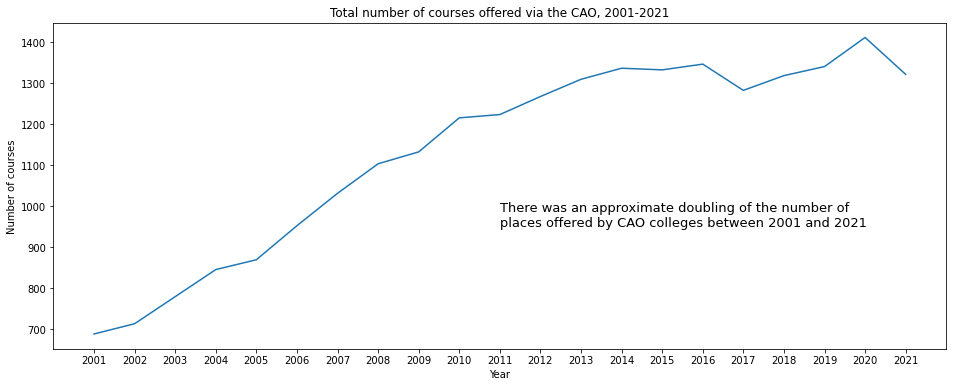

In [19]:
# Get array of total course counts per year
course_count = np.asarray(df.loc[:,(slice(None),'EOS')].count())
course_count = np.flip(course_count)

# Get array of years (for axis labelling)
years = np.asarray(df.columns.levels[0][0:-1])

with mpl.rc_context(rc={'figure.figsize':(16,6)}):
    fig, ax = plt.subplots()
    ax.plot(years, course_count)
    ax.set_title("Total number of courses offered via the CAO, 2001-2021")
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of courses")
    ax.text(10, 950, "There was an approximate doubling of the number of \nplaces offered by CAO colleges between 2001 and 2021", fontsize=13)

In [20]:
# Get a dictionary of Institution codes and names
inst_names = df['Names']['Institution'].unique()
inst_codes = df.index.get_level_values(0).unique()
inst_dict = dict(zip(inst_codes, inst_names))

Course codes BN, DT, FT, TA, and TU all refer to different campuses, and different generations of Technological University Dublin, so all are recoded as TU. Institution name remains unchanged. 

In [21]:
# Give all of the campuses that come under the 'Technological University Dublin' the TU code 
df.rename(index={'BN': 'TU', 'DT': 'TU', 'FT': 'TU', 'TA': 'TU'}, inplace=True)

In [22]:
# Select only EOS columns and count the number of courses with EOS values for each year grouped by Institution
eos = df.loc[:,(slice(None), 'EOS')]
counts = eos.groupby('Institution Code').count().droplevel(1, axis=1).sort_index(axis=1)

A bar plot of the total number of courses offered by each institution over the period of interest. This plot also serves as a dictionary of institution codes and names. Technological University Dublin (TU) has offered more than twice the number of courses offered by its nearest competitor, Trinity College Dublin (TR), over the past 20 years. This isn't terribly surprising as TU has subsumed all of the erstwhile Dublin Institute of Technology campuses as well as Tallaght and Blanchardstown Institutes of Technology.

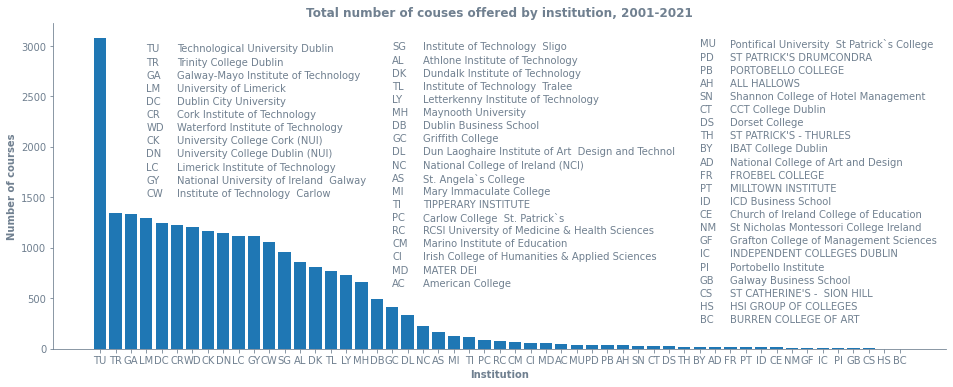

In [23]:
# Calculate total number couses offer by institution and sort
sums = counts.sum(axis=1).sort_values(ascending=False)

# Bar plot
with mpl.rc_context(rc={'figure.figsize':(16,6)}):
    fig, ax = plt.subplots()
    ax.bar(sums.index, sums)
    ax.set_xlabel('Institution', color='slategrey', fontweight='bold')
    ax.set_ylabel('Number of courses', color='slategrey', fontweight='bold')
    ax.set_title('Total number of couses offered by institution, 2001-2021', color='slategrey', fontweight='bold')
    ax.tick_params(axis='both', colors='slategrey')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('slategrey')
    ax.spines['bottom'].set_color('slategrey')

    # draw must be called for the tick labels to be populated
    plt.draw()
    ticklabels = ax.get_xticklabels(which='major')
    col = 'slategrey'
    
    # Draw the chart text in three columns
    # Col 1
    for i in range(12):
        # Get the current institution code from its ticklabel
        code = ticklabels[i].get_text()
        # Add the code and the matching institution name to the plot area
        ax.text(3, 0 - i * 130 + 3020,  ticklabels[i].get_text(), ha='left', va='top', color=col)
        ax.text(5, 0 - i * 130 + 3020,  inst_dict[code], ha='left', va='top', color=col)
    
    # Repeat for col 2
    for i in range(12,31):
        code = ticklabels[i].get_text()
        ax.text(19, 0 - i * 130 + 4600,  ticklabels[i].get_text(), ha='left', va='top', color=col)
        ax.text(21, 0 - i * 130 + 4600,  inst_dict[code], ha='left', va='top', color=col)
    
    # Repeat for col 3
    for i in range(31,53):
        code = ticklabels[i].get_text()
        ax.text(39, 0 - i * 130 + 7100,  ticklabels[i].get_text(), ha='left', va='top', color=col)
        ax.text(41, 0 - i * 130 + 7100,  inst_dict[code], ha='left', va='top', color=col)
        
    
    plt.show()

The line chart below, although ugly and difficult to make out in places, offers some quick insight into the develoment of course numbers offered by the various institutions. The left hand plot contains a line for each of the 57 insititutions in the dataset. In a previous step all of the courses offered by institutions that were ultimately to become part of Technological University Dublin (TU) were retoactively added to TU's courses. As a result, TU by far outstrips any othe institution in terms of number of courses offered. Furthermore, TU has demonstrated an extremely steep growth curve in the period, growing faster (again, in terms of number of courses offered) than any other institution. The strange spike in Trinity College (TR) courses in 2020 is merely an artefact of a technical data issue where the 2021 joint honours courses for Trinity College were not included in the original HTML files. They are included in the new Excel spreadsheet which was released since that portion of the project was complete but have not yet been added to the pandas dataframe used here. However, there is a real, very large, jump in the number of courses offered by TR from 2019-2020 when joint honours courses seem to have been added. At the other end of the scale, there are a number of institutions which offer, and have always offered, a steady low number of courses.

The plot on the left hand side displays the same data as the one on the right but with the upper-end outliers TU and TR removed, and with numerous institutions which offer very few courses also removed. Galway-Mayo Institute of Technology (GA) shows very strong growth since 2013 (and fairly persistent growth before that). Other institutions showing strong growth by this metric are the Limerick (LC), Cork (CR), Sligo (SG), and Carlow (CW) institutes of technology. The universities, Dublin City University (DC), University Colleges Dublin (DN) and Cork (CK), National University if Ireland Galway (GY), University of Limerick (LM), etc, all provide a relatively significant number of courses but in all cases that number is either stagnant or declining.

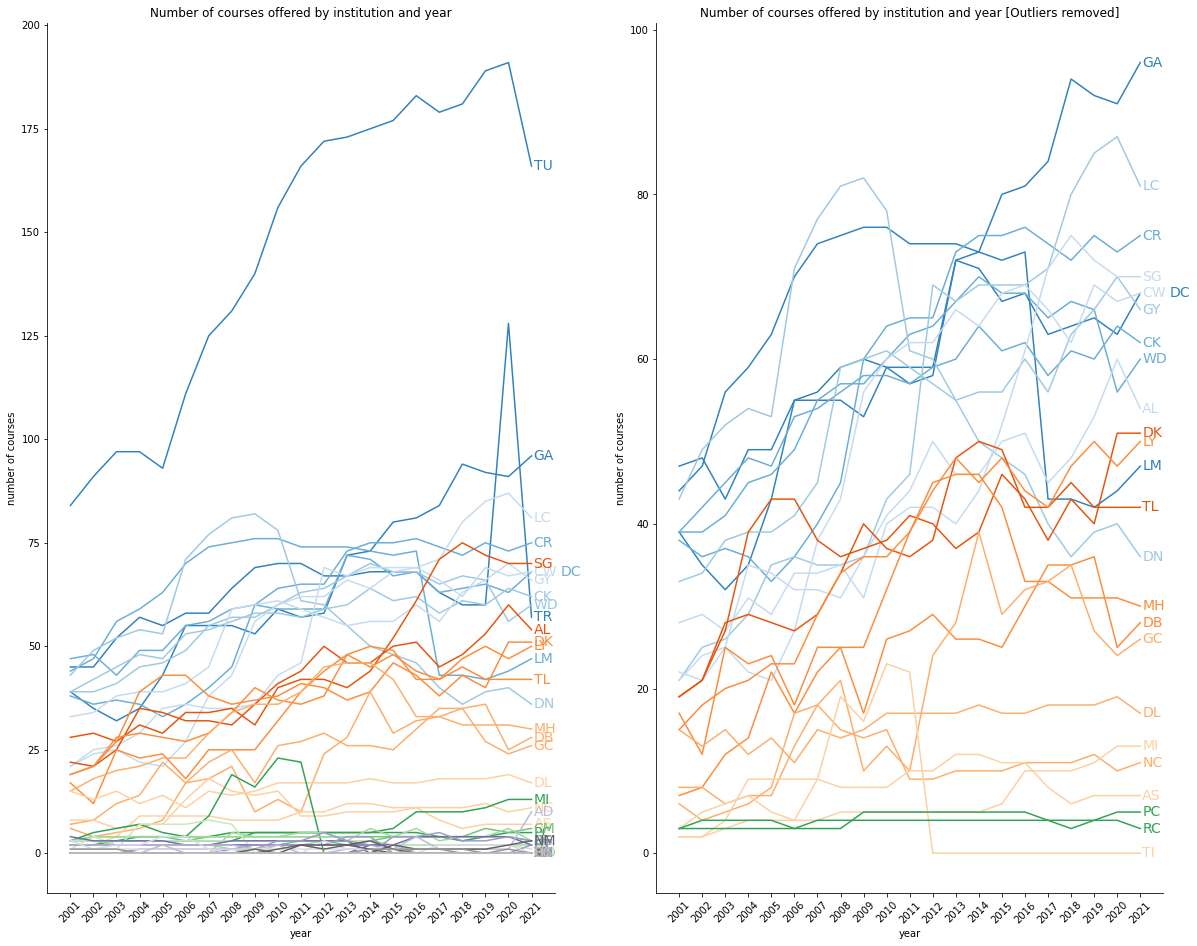

In [78]:
# Sort the course counts by total number of courses
counts_bysize = counts.reindex(sums.index)

# Plot number of courses 
with mpl.rc_context(rc={'figure.figsize': (20,16)}):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    data = np.asarray(counts_bysize).T
    labels = np.asarray(counts_bysize.index)

    # Colour the lines
    c = plt.cycler('color', plt.cm.tab20c(np.linspace(0, 1, 57)))
    ax1.set_prop_cycle(c)
    ax2.set_prop_cycle(c)

    ax1.plot(years, data)
    ax2.plot(years, data[:,2:27])
    
    ax1.set_title("Number of courses offered by institution and year")
    ax2.set_title("Number of courses offered by institution and year [Outliers removed]")
        
    # Annotate the lines
    labs = labels.copy()
    for ax in (ax1, ax2):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        for line, name in zip(ax.lines, labs):
            offset = -21
            if name == 'DC':
                offset = 6
            y = line.get_ydata()[-1]
            ax.annotate(name, xy=(1, y), xytext=(offset, 0), color=line.get_color(), 
                xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                size=14, va="center")
        ax.xaxis.set_tick_params(rotation=45)
        ax.set_ylabel("number of courses")
        ax.set_xlabel("year")
        labs = labels[2:27]
        
   
    plt.show()


625

In [56]:
# Check out strange Trinity College course count jump in 2020
df.loc[('TR',),(slice(None),'EOS')].count()

2021  EOS     57
2020  EOS    128
2019  EOS     60
2018  EOS     60
2017  EOS     63
2016  EOS     68
2015  EOS     68
2014  EOS     68
2013  EOS     67
2012  EOS     67
2011  EOS     70
2010  EOS     70
2009  EOS     69
2008  EOS     64
2007  EOS     58
2006  EOS     58
2005  EOS     55
2004  EOS     57
2003  EOS     52
2002  EOS     45
2001  EOS     45
dtype: int64

In [69]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df.loc[('TR',),(['2021', 'Names'], ['EOS', 'Course Name'])])

/home/fod/HDip/modules/fda/fundamentals-data-analysis/.venv/lib/python3.10/site-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


,2021,Names
,EOS,Course Name
Course Code,,
001,NaN,Two-subject Moderatorship ...
002,477.0,Music ...
003,543.0,History ...
004,589.0,Law ...
005,497.0,Philosophy ...
006,590.0,Psychology ...
007,564.0,Clinical Speech and Language Studies ...
008,NaN,World Religions and Theology





## Conclusion

In [60]:
df


2021                                            \
                                EOS Mid Level8   Test Not All    AQA New Comp   
Institution Code Course Code                                                    
AC               100            NaN NaN  False  False   False  False    False   
                 120          294.0 NaN   True  False   False  False    False   
                 121            NaN NaN  False  False   False  False    False   
                 137          270.0 NaN   True  False   False  False    False   
                 141            NaN NaN  False  False   False  False    False   
...                             ...  ..    ...    ...     ...    ...      ...   
WD               231          266.0 NaN   True  False   False  False    False   
                 232          261.0 NaN   True  False   False  False    False   
                 816            NaN NaN  False  False   False  False    False   
                 817            NaN NaN  False  False   False  False    False   
                 820            NaN NaN  False  False   False  False    False   

                               2020                ...     2002   2001      \
                                EOS    Mid Level8  ... New Comp    EOS Mid   
Institution Code Course Code                       ...                       
AC               100            NaN    NaN  False  ...    False    NaN NaN   
                 120          209.0  280.0   True  ...    False  225.0 NaN   
                 121            NaN    NaN  False  ...    False    NaN NaN   
                 137          252.0  270.0   True  ...    False    NaN NaN   
                 141            NaN    NaN  False  ...    False  200.0 NaN   
...                             ...    ...    ...  ...      ...    ...  ..   
WD               231            NaN    NaN  False  ...    False    NaN NaN   
                 232            NaN    NaN  False  ...    False    NaN NaN   
                 816            NaN    NaN  False  ...    False    NaN NaN   
                 817            NaN    NaN  False  ...    False    NaN NaN   
                 820            NaN    NaN  False  ...    False    NaN NaN   

                                                                    \
                             Level8   Test Not All    AQA New Comp   
Institution Code Course Code                                         
AC               100          False  False   False   True    False   
                 120           True  False   False  False    False   
                 121          False  False   False  False    False   
                 137          False  False   False  False    False   
                 141           True  False   False  False    False   
...                             ...    ...     ...    ...      ...   
WD               231          False  False   False  False    False   
                 232          False  False   False  False    False   
                 816          False  False   False  False    False   
                 817          False  False   False  False    False   
                 820          False  False   False  False    False   

                                                          Names  \
                                                    Institution   
Institution Code Course Code                                      
AC               100                           American College   
                 120                           American College   
                 121                           American College   
                 137                           American College   
                 141                           American College   
...                                                         ...   
WD               231          Waterford Institute of Technology   
                 232          Waterford Institute of Technology   
                 816          Waterford Institute of Technology   
                 8

## References

[1] https://www.independent.ie/life/family/learning/understanding-your-cao-course-guide-26505318.html

[2] https://docs.python.org/3/reference/lexical_analysis.html#formatted-string-literals

[3] https://pypi.org/project/tabula-py/

[4] https://github.com/tabulapdf/tabula-java

[5] https://tabula-py.readthedocs.io/en/latest/faq.html#how-to-use-area-option

[6] https://inkscape.org/